In [ ]:
# Create a method to find whether there is data shifting
## And which features caused data shifting

# Download the dataset here: https://www.kaggle.com/c/sberbank-russian-housing-market/data

In [25]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [26]:
train.head()

# price_doc is the label

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [27]:
train.dtypes

id                                         int64
timestamp                                 object
full_sq                                    int64
life_sq                                  float64
floor                                    float64
max_floor                                float64
material                                 float64
build_year                               float64
num_room                                 float64
kitch_sq                                 float64
state                                    float64
product_type                              object
sub_area                                  object
area_m                                   float64
raion_popul                                int64
green_zone_part                          float64
indust_part                              float64
children_preschool                         int64
preschool_quota                          float64
preschool_education_centers_raion          int64
children_school     

In [28]:
test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [29]:
# Preprocess data first, before checking data shifting

## Sometimes, the lowercase, uppercase for categorical data matters, here skip checking data consistency


## Deal with missing Data
for i in train.columns:
    if train[i].dtype == 'object':
        train[i] = train[i].fillna(train[i].mode().iloc[0])
    if (train[i].dtype == 'int64' or train[i].dtype == 'float64'):
        train[i] = train[i].fillna(np.nanmedian(train[i]))
    
for i in test.columns:
    if test[i].dtype == 'object':
        test[i] = test[i].fillna(test[i].mode().iloc[0])
    if (test[i].dtype == 'int64' or test[i].dtype == 'float64'):
        test[i] = test[i].fillna(np.nanmedian(test[i]))    
# with np.nanmedian, you can get median by ignoring NaN, otherwise, statistics.median could use NaN as median

In [31]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,12.0,1.0,1979.0,2.0,6.0,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,12.0,1.0,1979.0,2.0,6.0,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,12.0,1.0,1979.0,2.0,6.0,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,12.0,1.0,1979.0,2.0,6.0,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,12.0,1.0,1979.0,2.0,6.0,...,319,108,17,135,236,2,91,195,14,16331452


In [32]:
train.timestamp.unique()

array(['2011-08-20', '2011-08-23', '2011-08-27', ..., '2015-06-27',
       '2015-06-29', '2015-06-30'], dtype=object)

In [33]:
## Categorical to Numerical (people call it label encoding, I think this name is confusing)
number = LabelEncoder()
for i in train.columns:
    if (train[i].dtype == 'object'):
        train[i] = number.fit_transform(train[i].astype('str'))
        train[i] = train[i].astype('object')

for i in test.columns:
    if (test[i].dtype == 'object'):
        test[i] = number.fit_transform(test[i].astype('str'))
        test[i] = test[i].astype('object')

In [34]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,0,43,27.0,4.0,12.0,1.0,1979.0,2.0,6.0,...,9,4,0,13,22,1,0,52,4,5850000
1,2,1,34,19.0,3.0,12.0,1.0,1979.0,2.0,6.0,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2,43,29.0,2.0,12.0,1.0,1979.0,2.0,6.0,...,10,3,0,11,27,0,4,67,10,5700000
3,4,3,89,50.0,9.0,12.0,1.0,1979.0,2.0,6.0,...,11,2,1,4,4,0,0,26,3,13100000
4,5,4,77,77.0,4.0,12.0,1.0,1979.0,2.0,6.0,...,319,108,17,135,236,2,91,195,14,16331452


In [35]:
## create this new col "origin" to tell which set comes from train, which comes from test
train['origin'] = 0
test['origin'] = 1
training = train.drop('price_doc',axis=1) # drop the label

In [36]:
## taking sample from training and test data
training = training.sample(9000, random_state=77)
testing = test.sample(7000, random_state=99)

In [37]:
## combining random samples, seperate 'origin' col with the data
combi = training.append(testing)
y = combi['origin']
combi.drop('origin',axis=1,inplace=True)

In [40]:
# Find drifting features can be dropped, put into drop_list
## If a feature has average score > 0.8, put into drop_list. 
## Because it means the feature could decide it's "train" or "test"

model = RandomForestClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf = 5)
drop_list = []

for i in combi.columns:
    score = cross_val_score(model,pd.DataFrame(combi[i]),y,cv=5,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        drop_list.append(i)
        print(i,np.mean(score))

('id', 1.0)
('timestamp', 0.95935706349206351)
('kitch_sq', 0.89323138888888887)
('cafe_sum_500_min_price_avg', 0.83561873015873012)
('cafe_avg_price_500', 0.83495988095238105)


In [42]:
# How to treat drifting features in order to improve final model prediction

training = train.drop('origin',axis=1)
testing = test.drop('origin',axis=1)

# using regressor here is because of the label is numerical
rf = RandomForestRegressor(n_estimators=200, max_depth=4,max_features=10)

rf.fit(training.drop('price_doc',axis=1),training['price_doc'])   # it ignores id automatically
pred = rf.predict(testing)

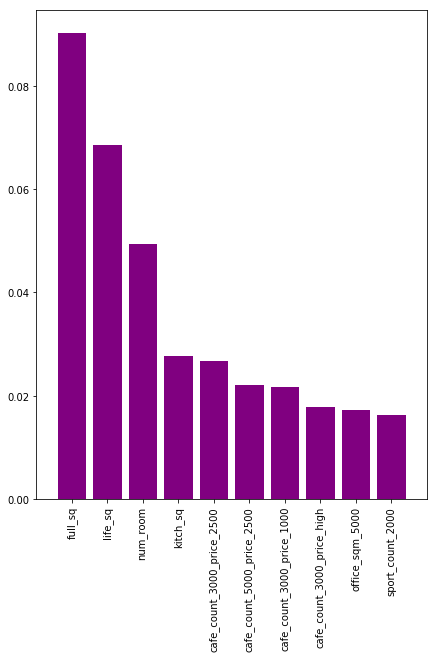

In [43]:
# Dropping drifting features but check feature importance first
## plotting feature importance (top 10) and find whether there is drifting features are important
features = training.columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:10]

#plot
plt.figure(figsize=(7,9))
plt.bar(range(len(indices)), imp[indices], color = 'purple', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

# kitch_sq is important, although it's showing drifting, keep this feature

In [45]:
## dropping drifting features which are not important.
drift_train = training.drop(['id','cafe_sum_500_min_price_avg','cafe_avg_price_500'], axis=1)
drift_test = testing.drop(['id','cafe_sum_500_min_price_avg','cafe_avg_price_500'], axis=1)

rf = RandomForestRegressor(n_estimators=200, max_depth=4,max_features=10)
rf.fit(drift_train.drop('price_doc',axis=1),training['price_doc'])

# submit your result to Kaggle: https://www.kaggle.com/c/sberbank-russian-housing-market/data
pred = rf.predict(drift_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = test['id']
sub = sub[['id','price_doc']]
sub.to_csv('without_drifting.csv', index=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=10, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)